## Install libraries

In [1]:
!pip install jiwer bert_score num2words

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━

In [81]:
import re
from sentence_transformers import SentenceTransformer, util
import spacy
from jiwer import wer, mer
import difflib
from bert_score import score as bert_score
import unicodedata
from num2words import num2words
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Image

## Help functions

In [3]:
def digits_to_words(text):
    # Replace digits and sequences with words
    def replace(match):
        return ' '.join(num2words(char) for char in match.group() if char.isdigit())
    return re.sub(r'\d+', replace, text)

def clean_text(text):
    # Normalize unicode characters (e.g., curly quotes to ASCII)
    text = unicodedata.normalize("NFKD", text)

    # Lowercase everything
    text = text.lower()

    # Replace curly/smart quotes with straight ones
    text = text.replace("’", "'").replace("‘", "'").replace("“", '"').replace("”", '"')

    # Remove all apostrophes (optionally keep them if needed)
    text = re.sub(r"'", "", text)

    # Remove all other punctuation except periods (if needed)
    text = re.sub(r"[^\w\s]", "", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [ ]:
def evaluate_transcriptions(manual, whisper):
    # Semantic similarity
    semantic_similarity = util.cos_sim(
        model.encode(manual), model.encode(whisper)
    ).item()

    # WER and MER
    wer_score_value = wer(manual, whisper)
    mer_score_value = mer(manual, whisper)

    # Levenshtein Ratio
    lev_ratio = difflib.SequenceMatcher(None, manual, whisper).ratio()

    # Content word analysis
    def content_words(text):
        doc = nlp(text.lower())
        return set(token.text for token in doc if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV'])

    manual_content = content_words(manual)
    whisper_content = content_words(whisper)
    intersection = manual_content & whisper_content

    content_accuracy = len(intersection) / len(manual_content) if manual_content else 0
    content_precision = len(intersection) / len(whisper_content) if whisper_content else 0
    content_recall = len(intersection) / len(manual_content) if manual_content else 0

    # BERTScore
    P, R, F1 = bert_score([whisper], [manual], lang="en", rescale_with_baseline=True)

    return pd.DataFrame({
        "Metric": [
            "Semantic Similarity",
            "Word Error Rate (WER)",
            "Levenshtein Match Ratio",
            "Match Error Rate (MER)",
            "Content Word Accuracy",
            "Content Word Precision",
            "Content Word Recall",
            "BERTScore Precision",
            "BERTScore Recall",
            "BERTScore F1"
        ],
        "Value": [
            round(semantic_similarity, 3),
            round(wer_score_value, 3),
            round(lev_ratio, 3),
            round(mer_score_value, 3),
            round(content_accuracy, 3),
            round(content_precision, 3),
            round(content_recall, 3),
            round(P.item(), 3),
            round(R.item(), 3),
            round(F1.item(), 3)
        ]
    })

In [79]:
# Function to visualize results
def plot_metrics(df, file_path, title):
    error_metrics = ["Word Error Rate (WER)", "Match Error Rate (MER)"]
    positive_metrics = [
        "Semantic Similarity", "Levenshtein Match Ratio", "Content Word Accuracy",
        "Content Word Precision", "Content Word Recall", "BERTScore Precision",
        "BERTScore Recall", "BERTScore F1"
    ]

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    df.loc[error_metrics].plot(kind='bar', ax=axes[0], legend=False)
    axes[0].set_title("Error Metrics (Lower is Better)")
    axes[0].set_ylabel("Score")
    axes[0].set_ylim(0, 1.1)
    axes[0].grid(axis='y', linestyle='--', alpha=0.6)
    axes[0].set_xticklabels(df.loc[error_metrics].index, rotation=45, ha='right')

    df.loc[positive_metrics].plot(kind='bar', ax=axes[1], legend=False)
    axes[1].set_title("Semantic & Content Metrics (Higher is Better)")
    axes[1].set_ylabel("Score")
    axes[1].set_ylim(0, 1.1)
    axes[1].grid(axis='y', linestyle='--', alpha=0.6)
    axes[1].set_xticklabels(df.loc[positive_metrics].index, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()



In [65]:
# Define error metrics
error_metrics = [
    "Word Error Rate (WER)",
    "Match Error Rate (MER)"
]

In [66]:
# Define positive metrics
positive_metrics = [
    "Semantic Similarity",
    "Levenshtein Match Ratio",
    "Content Word Accuracy",
    "Content Word Precision",
    "Content Word Recall",
    "BERTScore Precision",
    "BERTScore Recall",
    "BERTScore F1"
]

In [60]:
FILLERS = {'um', 'uh', 'ah', 'er', 'hmm', 'eh', 'mm', 'erm'}

def clean_fillers(text):
    pattern = r'\b(?:' + '|'.join(re.escape(f) for f in FILLERS) + r')\b[.,!?]?\s*'
    cleaned = re.sub(pattern, '', text, flags=re.IGNORECASE)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

## Defining input and output folders

### Input folders

In [52]:
import os

input_manual = '../data/manual_transcriptions'
input_whisper = '../data/whisper_transcriptions'

### For cleaned transcriptions:

In [53]:
output_dir_manual_cleaned = '../data/manual_transcriptions/cleaned'

output_dir_whisper_cleaned = '../data/whisper_transcriptions/cleaned'

### For no-fillers transcriptions:

In [72]:
output_dir_whisper_fillers = '../data/whisper_transcriptions/fillers'

output_dir_manual_fillers = '../data/manual_transcriptions/fillers'

In [55]:
for path in [output_dir_manual_cleaned, output_dir_whisper_cleaned, output_dir_whisper_fillers, output_dir_manual_fillers]:
    os.makedirs(path, exist_ok=True)

### For metrics and visualizations

In [71]:
output_metrics = '../results/metrics'
output_vis = '../results/vis'

## Load models

In [59]:
# Load spacy & sentence transformer
nlp = spacy.load("en_core_web_sm")
model = SentenceTransformer("all-MiniLM-L6-v2")

# Video 1: Mike Caputo

### Preprocessing

First we'll take a look at the raw transcriptions:

In [57]:
f = open(f"{input_manual}/manual_1.txt")
manual_raw = f.read()
f.close()

print("******************* MANUAL RAW TRANSCRIPTION *******************")
print(manual_raw)

f = open(f"{input_whisper}/whisper_1.txt")
whisper_raw = f.read()
f.close()

print("******************* WHISPER RAW TRANSCRIPTION *******************")
print(whisper_raw)

******************* MANUAL RAW TRANSCRIPTION *******************
I… Mike Caputo.
I was… um… seven years ago. And…
Um… well, um… worked… Autodesk. Um… seven, seven. Sales, sales. Um, worldwide. And very good, yeah.
That's my wife.
Um… she is… speech. Um…
Yeah, yeah.
Aphasia.
Um, I, I, well, I do.
Voices of Hope Aphasia.
Um Peterburg… um Peterburg. Um, and um Dr Hinckley and um… and um… myself… um… founder. Founder for me.
And um… I… um… members… um… members… um… the… the… uh… members. Probably seven, six… zero people.
Yes.
Yes.
No, it’s programs.
It’s it’s… um… three month, three days. Um… um… Monday, Wednesday, Friday.
And the, the um, and they laugh, and and talked.
And um… music, hear, this this beautiful.
It’s… you know…
Um… it’s, it’s hard.
It’s um… Well it’s um… speech.
It’s like um… words that don’t understand.
Brain is good, you know.
But it's um… speech like um… I don’t know… it’s like words… um… yuk!
Yeah.
Bye bye!
******************* WHISPER RAW TRANSCRIPTION ****************

Now we will clean the transcriptions and save them:

In [58]:
# Cleaned versions for analysis
manual = clean_text(manual_raw)
print("******************* MANUAL TRANSCRIPTION *******************")
print(manual)

******************* MANUAL TRANSCRIPTION *******************
i mike caputo i was um seven years ago and um well um worked autodesk um seven seven sales sales um worldwide and very good yeah thats my wife um she is speech um yeah yeah aphasia um i i well i do voices of hope aphasia um peterburg um peterburg um and um dr hinckley and um and um myself um founder founder for me and um i um members um members um the the uh members probably seven six zero people yes yes no its programs its its um three month three days um um monday wednesday friday and the the um and they laugh and and talked and um music hear this this beautiful its you know um its its hard its um well its um speech its like um words that dont understand brain is good you know but its um speech like um i dont know its like words um yuk yeah bye bye


In [34]:
with open(f"{output_dir_manual_cleaned}/cleaned_1.txt", 'w') as f:
    f.write(manual)

In [11]:
whisper = clean_text(whisper_raw)
print("******************* WHISPER TRANSCRIPTION *******************")
print(whisper)

******************* WHISPER TRANSCRIPTION *******************
mike caputo i was seven years ago well worked on a desk seven sales and worldwide and very good thats my wife shes a speech yeah yeah phasia i well i do voices of hope aphasia peterburg and dr hinkley and myself founder founder for me and i members members the the members probably seven six zero people yes yes no its programs its three months three days monday wednesday friday and the and they laugh and and talked music here its just beautiful its you know its hard its well its speech its like words that dont understand brain is good you know but its speech like i dont know its like words yuck yeah bye bye


In [39]:
with open(f"{output_dir_whisper_cleaned}/cleaned_1.txt", 'w') as f:
    f.write(whisper)

And as the last preprocessing step, we will remove fillers, and save the no-fillers transcriptions:

In [20]:
# No filler
manual_fillers = clean_fillers(manual)
print("******************* MANUAL TRANSCRIPTION WITHOUT FILLERS *******************")
print(manual_fillers)

******************* MANUAL TRANSCRIPTION WITHOUT FILLERS *******************
i mike caputo i was seven years ago and well worked autodesk seven seven sales sales worldwide and very good yeah thats my wife she is speech yeah yeah aphasia i i well i do voices of hope aphasia peterburg peterburg and dr hinckley and and myself founder founder for me and i members members the the members probably seven six zero people yes yes no its programs its its three month three days monday wednesday friday and the the and they laugh and and talked and music hear this this beautiful its you know its its hard its well its speech its like words that dont understand brain is good you know but its speech like i dont know its like words yuk yeah bye bye


In [43]:
with open(f'{output_dir_manual_fillers}/fillers_1.txt', 'w') as f:
    f.write(manual_fillers)

In [45]:
whisper_fillers = clean_fillers(whisper)
print("******************* MANUAL TRANSCRIPTION WITHOUT FILLERS *******************")
print(whisper_fillers)

******************* MANUAL TRANSCRIPTION WITHOUT FILLERS *******************
mike caputo i was seven years ago well worked on a desk seven sales and worldwide and very good thats my wife shes a speech yeah yeah phasia i well i do voices of hope aphasia peterburg and dr hinkley and myself founder founder for me and i members members the the members probably seven six zero people yes yes no its programs its three months three days monday wednesday friday and the and they laugh and and talked music here its just beautiful its you know its hard its well its speech its like words that dont understand brain is good you know but its speech like i dont know its like words yuck yeah bye bye


In [44]:
with open(f'{output_dir_whisper_fillers}/fillers_1.txt', 'w') as f:
    f.write(whisper_fillers)

### Results

#### On raw transcriptions

In [61]:
results_raw_1 = evaluate_transcriptions(manual_raw, whisper_raw)

print("=== Whisper vs Manual Transcript (RAW) ===")
print(results_raw_1)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== Whisper vs Manual Transcript (RAW) ===
                    Metric  Value
0      Semantic Similarity  0.727
1    Word Error Rate (WER)  0.704
2  Levenshtein Match Ratio  0.076
3   Match Error Rate (MER)  0.704
4    Content Word Accuracy  0.794
5   Content Word Precision  0.818
6      Content Word Recall  0.794
7      BERTScore Precision  0.494
8         BERTScore Recall  0.155
9             BERTScore F1  0.320


#### On cleaned transcriptions

In [62]:
results_1 = evaluate_transcriptions(manual, whisper)

print("=== Whisper vs Manual Transcript (PREPROCESSED) ===")
print(results_1)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== Whisper vs Manual Transcript (PREPROCESSED) ===
                    Metric  Value
0      Semantic Similarity  0.840
1    Word Error Rate (WER)  0.340
2  Levenshtein Match Ratio  0.076
3   Match Error Rate (MER)  0.340
4    Content Word Accuracy  0.875
5   Content Word Precision  0.800
6      Content Word Recall  0.875
7      BERTScore Precision  0.585
8         BERTScore Recall  0.347
9             BERTScore F1  0.464


#### On no-fillers transcriptions

In [63]:
results_1_fillers = evaluate_transcriptions(manual_fillers, whisper_fillers)

print("=== Whisper vs Manual Transcript (NO FILLERS) ===")
print(results_1_fillers)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== Whisper vs Manual Transcript (NO FILLERS) ===
                    Metric  Value
0      Semantic Similarity  0.924
1    Word Error Rate (WER)  0.181
2  Levenshtein Match Ratio  0.088
3   Match Error Rate (MER)  0.180
4    Content Word Accuracy  0.853
5   Content Word Precision  0.829
6      Content Word Recall  0.853
7      BERTScore Precision  0.757
8         BERTScore Recall  0.746
9             BERTScore F1  0.752


In [64]:
merged_results_1 = pd.DataFrame({
    'Metric': results_raw_1['Metric'],
    'Raw': results_raw_1['Value'].values,
    'Cleaned': results_1['Value'].values,
    'No Fillers': results_1_fillers['Value'].values
})

# Set index to metric names
merged_results_1.set_index("Metric", inplace=True)

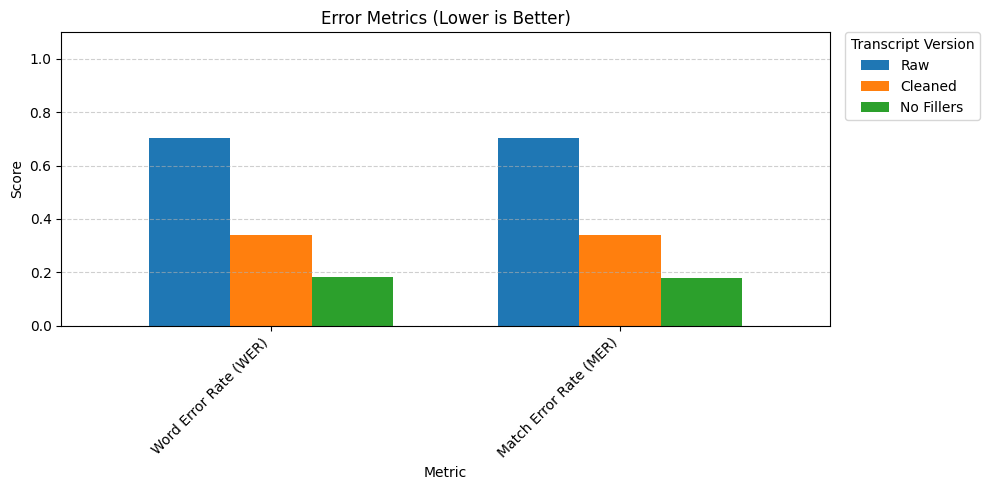

In [67]:
plot_metrics(merged_results_1, error_metrics, "Error Metrics (Lower is Better)")

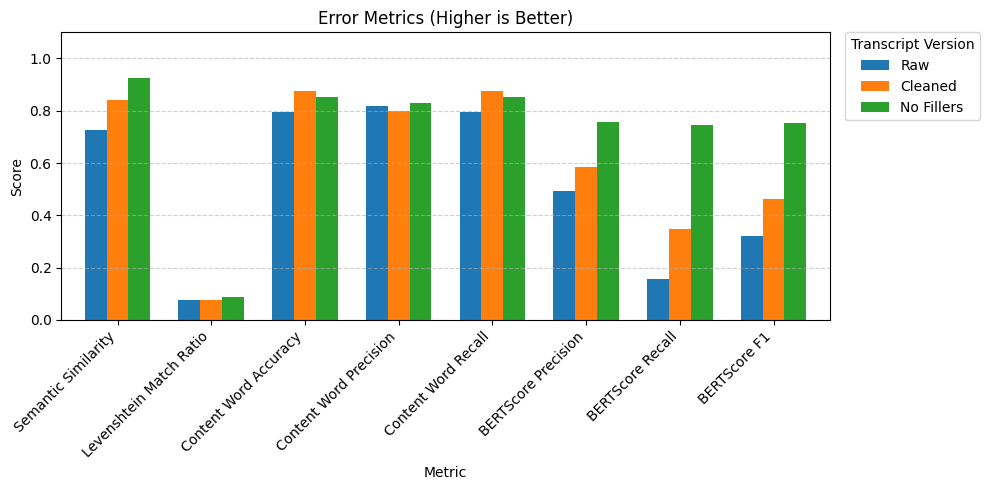

In [68]:
plot_metrics(merged_results_1, positive_metrics, "Error Metrics (Higher is Better)")

# Run for all transcripts

In [ ]:
# Loop over all transcript pairs
file_indices = sorted([
    int(f.stem.split("_")[-1])
    for f in Path(input_manual).glob("manual_*.txt")
])

for idx in file_indices:
    # Load raw transcripts
    with open(f"{input_manual}/manual_{idx}.txt", 'r') as f:
        manual_raw = f.read()
    with open(f"{input_whisper}/whisper_{idx}.txt", 'r') as f:
        whisper_raw = f.read()

    # Cleaned versions
    manual_cleaned = clean_text(manual_raw)
    whisper_cleaned = clean_text(whisper_raw)

    # No filler versions
    manual_fillers = clean_fillers(manual_cleaned)
    whisper_fillers = clean_fillers(whisper_cleaned)

    # Save cleaned and filler versions
    with open(f"{output_dir_manual_cleaned}/cleaned_{idx}.txt", 'w') as f:
        f.write(manual_cleaned)
    with open(f"{output_dir_whisper_cleaned}/cleaned_{idx}.txt", 'w') as f:
        f.write(whisper_cleaned)
    with open(f"{output_dir_manual_fillers}/fillers_{idx}.txt", 'w') as f:
        f.write(manual_fillers)
    with open(f"{output_dir_whisper_fillers}/fillers_{idx}.txt", 'w') as f:
        f.write(whisper_fillers)

    # Run evaluation
    results_raw = evaluate_transcriptions(manual_raw, whisper_raw)
    results_cleaned = evaluate_transcriptions(manual_cleaned, whisper_cleaned)
    results_fillers = evaluate_transcriptions(manual_fillers, whisper_fillers)

    merged = pd.DataFrame({
        'Metric': results_raw['Metric'],
        'Raw': results_raw['Value'],
        'Cleaned': results_cleaned['Value'],
        'No Fillers': results_fillers['Value']
    }).set_index("Metric")

    # Save metrics
    merged.to_csv(f"{output_metrics}/metrics_{idx}.csv")

    # Save plot
    plot_metrics(merged, f"{output_vis}/vis_{idx}.png", f"Transcript {idx}")

# Video 2: Kent

In [107]:
df_video2 = pd.read_csv("../results/metrics/metrics_2.csv")

# Display DataFrame
df_video2

,Metric,Raw,Cleaned,No Fillers
0,Semantic Similarity,0.280,0.322,0.325
1,Word Error Rate (WER),1.000,0.744,0.750
2,Levenshtein Match Ratio,0.074,0.104,0.106
3,Match Error Rate (MER),1.000,0.727,0.714
4,Content Word Accuracy,0.167,0.200,0.200
5,Content Word Precision,0.200,0.125,0.125
6,Content Word Recall,0.167,0.200,0.200
7,BERTScore Precision,0.215,0.232,0.262
8,BERTScore Recall,-0.060,0.129,0.182
9,BERTScore F1,0.075,0.182,0.223


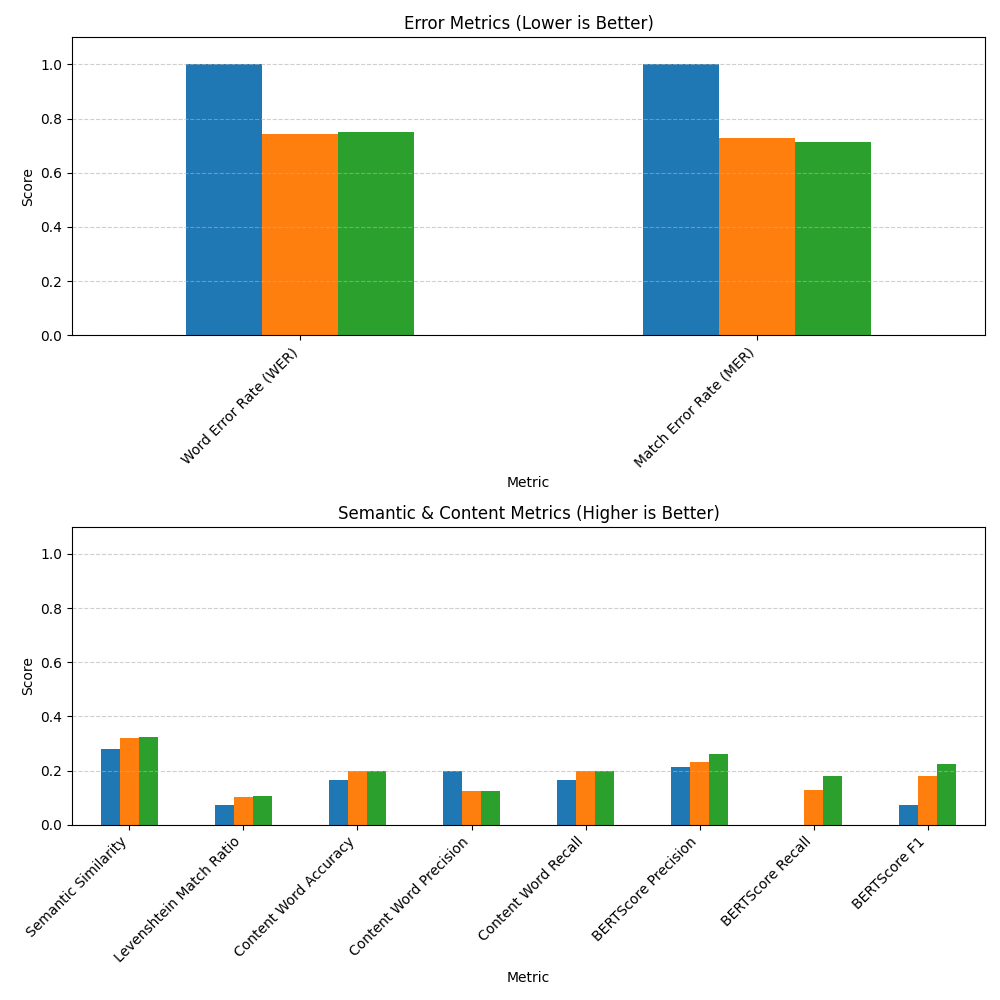

In [93]:
Image("../results/vis/vis_2.png")

# Video 3: Jan - Aphasia

In [106]:
df_video3 = pd.read_csv("../results/metrics/metrics_3.csv")

# Display DataFrame
df_video3

,Metric,Raw,Cleaned,No Fillers
0,Semantic Similarity,0.482,0.615,0.624
1,Word Error Rate (WER),0.912,0.667,0.615
2,Levenshtein Match Ratio,0.565,0.642,0.684
3,Match Error Rate (MER),0.912,0.667,0.615
4,Content Word Accuracy,0.727,0.667,0.667
5,Content Word Precision,0.667,0.800,0.800
6,Content Word Recall,0.727,0.667,0.667
7,BERTScore Precision,0.399,0.261,0.348
8,BERTScore Recall,-0.168,-0.213,-0.053
9,BERTScore F1,0.101,0.014,0.141


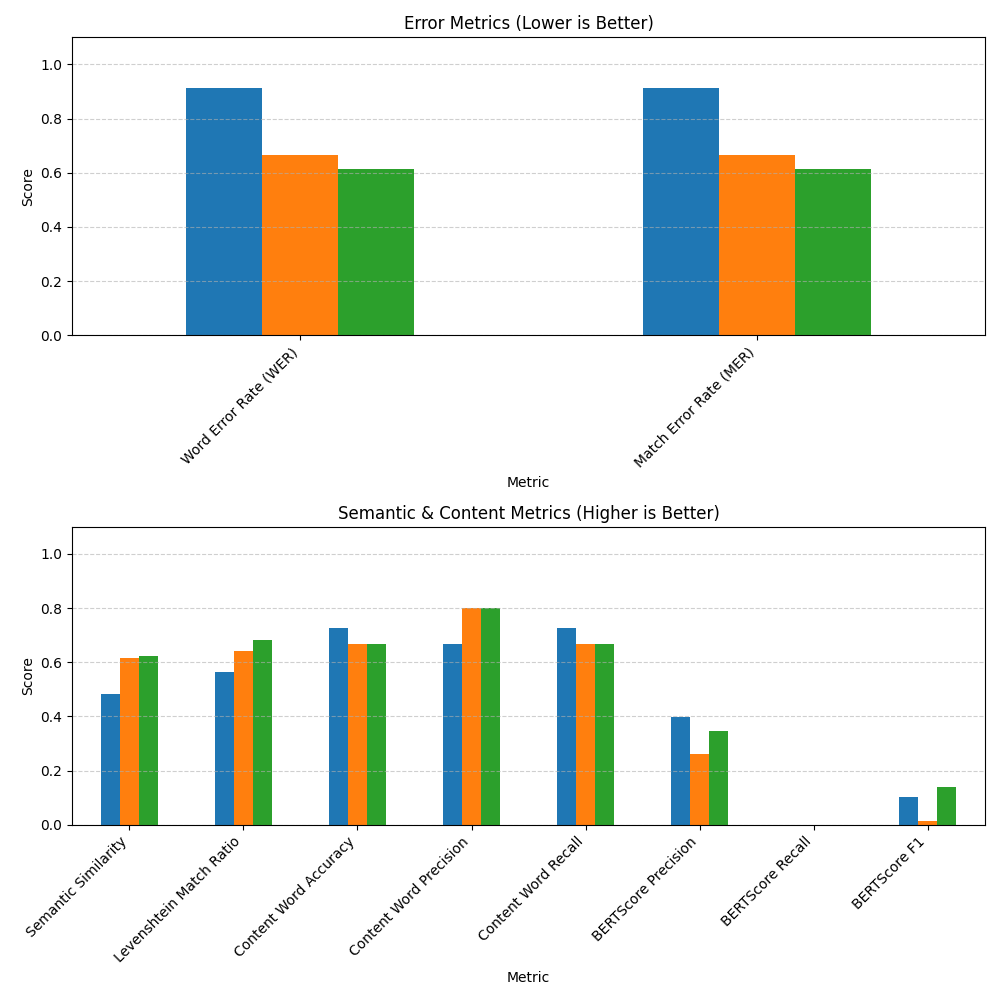

In [97]:
Image("../results/vis/vis_3.png")

# Video 4: Jan - Wedding

In [105]:
df_video4 = pd.read_csv("../results/metrics/metrics_4.csv")

# Display DataFrame
df_video4

,Metric,Raw,Cleaned,No Fillers
0,Semantic Similarity,0.434,0.430,0.428
1,Word Error Rate (WER),1.200,1.040,1.200
2,Levenshtein Match Ratio,0.210,0.559,0.534
3,Match Error Rate (MER),0.769,0.667,0.667
4,Content Word Accuracy,0.667,0.700,0.667
5,Content Word Precision,0.545,0.467,0.400
6,Content Word Recall,0.667,0.700,0.667
7,BERTScore Precision,0.167,0.220,0.078
8,BERTScore Recall,0.184,0.293,0.160
9,BERTScore F1,0.176,0.258,0.120


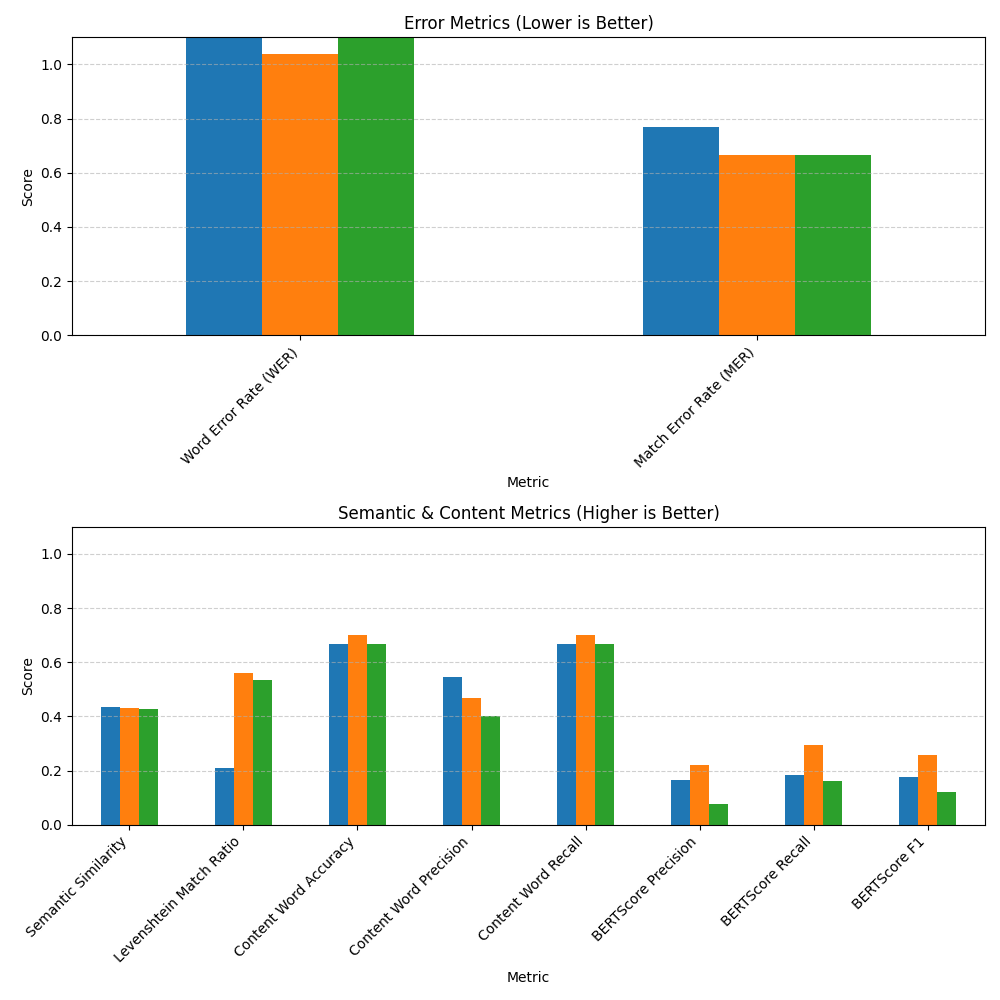

In [96]:
Image("../results/vis/vis_4.png")

# Video 5: Jan - TV Guide

In [104]:
df_video5 = pd.read_csv("../results/metrics/metrics_5.csv")

# Display DataFrame
df_video5

,Metric,Raw,Cleaned,No Fillers
0,Semantic Similarity,0.759,0.812,0.868
1,Word Error Rate (WER),0.782,0.455,0.302
2,Levenshtein Match Ratio,0.303,0.798,0.879
3,Match Error Rate (MER),0.782,0.455,0.302
4,Content Word Accuracy,0.643,0.643,0.688
5,Content Word Precision,0.750,0.692,0.846
6,Content Word Recall,0.643,0.643,0.688
7,BERTScore Precision,0.332,0.561,0.655
8,BERTScore Recall,0.052,0.233,0.537
9,BERTScore F1,0.190,0.393,0.596


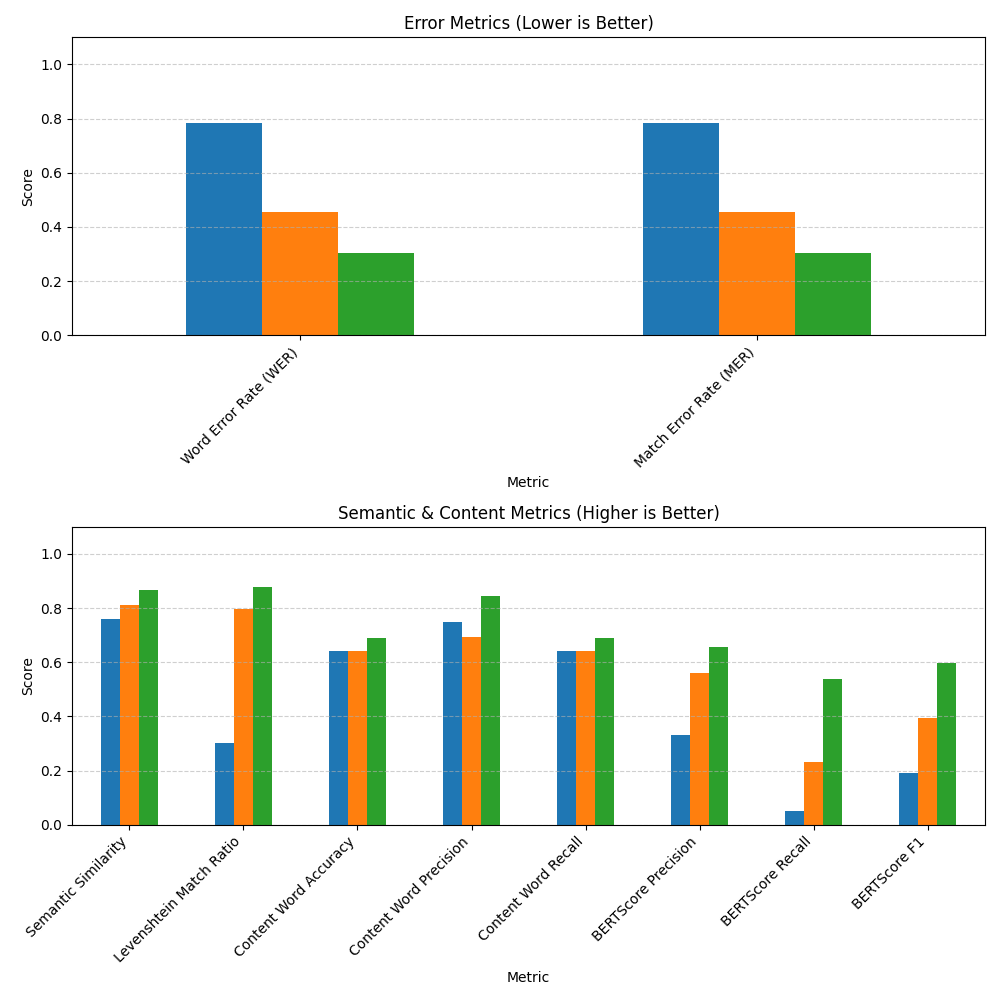

In [95]:
Image("../results/vis/vis_5.png")

# Video 6: Jan - T-shirt

In [103]:
df_video6 = pd.read_csv("../results/metrics/metrics_6.csv")

# Display DataFrame
df_video6

,Metric,Raw,Cleaned,No Fillers
0,Semantic Similarity,0.934,0.961,0.966
1,Word Error Rate (WER),0.532,0.170,0.167
2,Levenshtein Match Ratio,0.745,0.865,0.878
3,Match Error Rate (MER),0.510,0.163,0.152
4,Content Word Accuracy,0.625,0.875,0.875
5,Content Word Precision,0.769,0.875,0.933
6,Content Word Recall,0.625,0.875,0.875
7,BERTScore Precision,0.602,0.719,0.721
8,BERTScore Recall,0.583,0.707,0.747
9,BERTScore F1,0.593,0.713,0.734


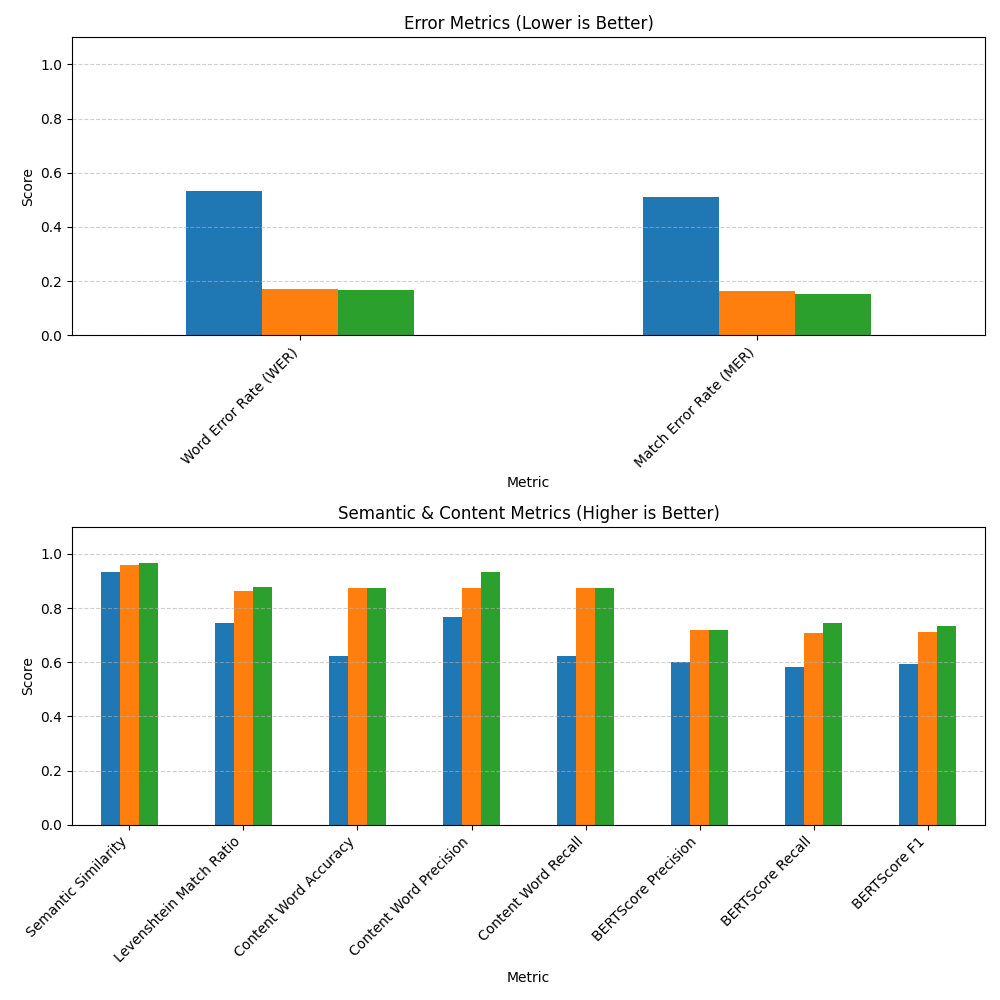

In [94]:
Image("../results/vis/vis_6.png")

# Video 7: Jan - Depression

In [102]:
df_video7 = pd.read_csv("../results/metrics/metrics_7.csv")

# Display DataFrame
df_video7

,Metric,Raw,Cleaned,No Fillers
0,Semantic Similarity,0.736,0.846,0.845
1,Word Error Rate (WER),0.717,0.377,0.289
2,Levenshtein Match Ratio,0.291,0.046,0.743
3,Match Error Rate (MER),0.717,0.377,0.283
4,Content Word Accuracy,0.765,0.824,0.824
5,Content Word Precision,0.867,0.875,0.875
6,Content Word Recall,0.765,0.824,0.824
7,BERTScore Precision,0.474,0.597,0.705
8,BERTScore Recall,0.326,0.402,0.632
9,BERTScore F1,0.400,0.498,0.669


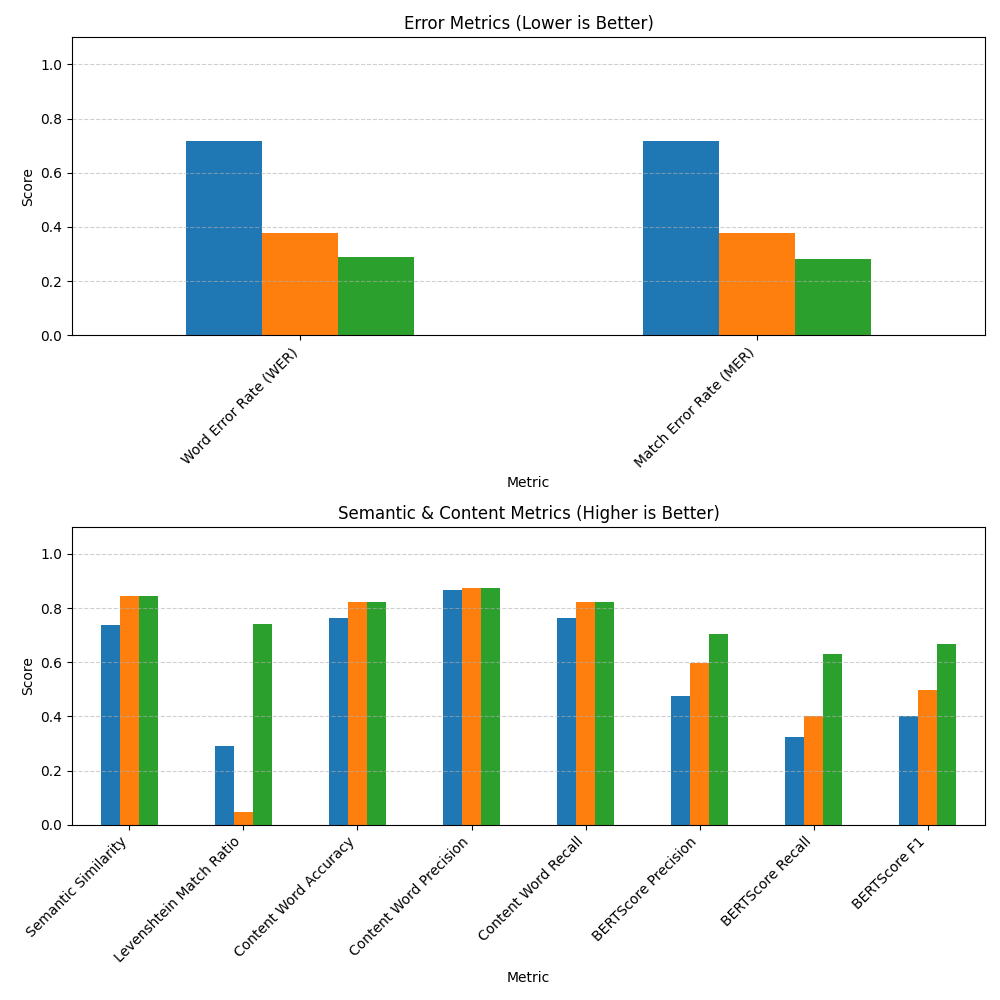

In [92]:
Image("../results/vis/vis_7.png")

# Video 8: Jan - Acceptance

In [101]:
df_video8 = pd.read_csv("../results/metrics/metrics_8.csv")

# Display DataFrame
df_video8

,Metric,Raw,Cleaned,No Fillers
0,Semantic Similarity,0.843,0.846,0.835
1,Word Error Rate (WER),0.525,0.279,0.292
2,Levenshtein Match Ratio,0.495,0.241,0.336
3,Match Error Rate (MER),0.492,0.262,0.275
4,Content Word Accuracy,0.667,0.786,0.786
5,Content Word Precision,0.714,0.846,0.786
6,Content Word Recall,0.667,0.786,0.786
7,BERTScore Precision,0.480,0.595,0.587
8,BERTScore Recall,0.471,0.599,0.580
9,BERTScore F1,0.476,0.598,0.584


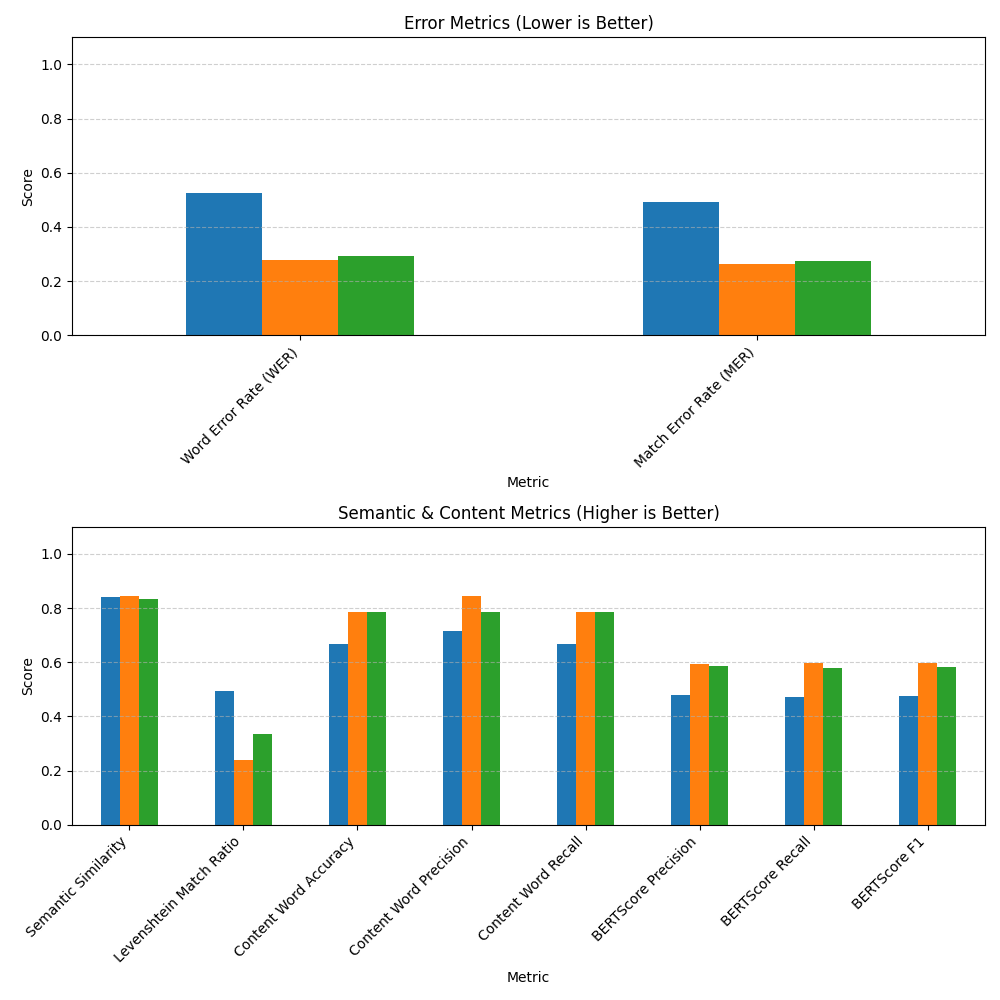

In [91]:
Image("../results/vis/vis_8.png")

# Video 9: Mild Aphasia (synthetic)

In [100]:
df_video9 = pd.read_csv("../results/metrics/metrics_9.csv")

# Display DataFrame
df_video9

,Metric,Raw,Cleaned,No Fillers
0,Semantic Similarity,0.950,0.959,0.992
1,Word Error Rate (WER),0.397,0.184,0.070
2,Levenshtein Match Ratio,0.440,0.631,0.778
3,Match Error Rate (MER),0.397,0.182,0.069
4,Content Word Accuracy,1.000,0.964,0.964
5,Content Word Precision,1.000,1.000,1.000
6,Content Word Recall,1.000,0.964,0.964
7,BERTScore Precision,0.773,0.743,0.886
8,BERTScore Recall,0.599,0.573,0.874
9,BERTScore F1,0.685,0.658,0.880


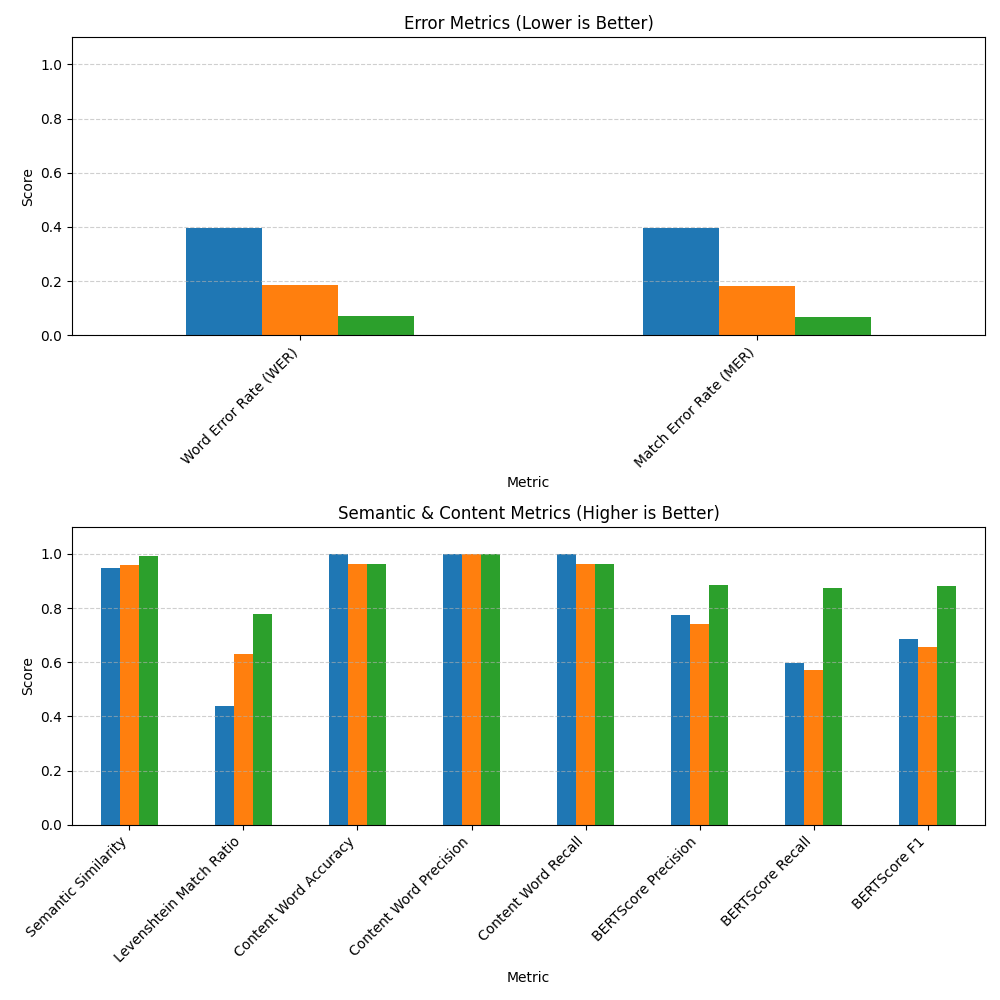

In [90]:
Image("../results/vis/vis_9.png")

# Video 10: Moderate Aphasia (synthetic)

In [99]:
df_video10 = pd.read_csv("../results/metrics/metrics_10.csv")

# Display DataFrame
df_video10

,Metric,Raw,Cleaned,No Fillers
0,Semantic Similarity,0.806,0.896,0.957
1,Word Error Rate (WER),0.868,0.338,0.172
2,Levenshtein Match Ratio,0.012,0.313,0.739
3,Match Error Rate (MER),0.868,0.338,0.172
4,Content Word Accuracy,0.905,1.000,1.000
5,Content Word Precision,0.950,1.000,1.000
6,Content Word Recall,0.905,1.000,1.000
7,BERTScore Precision,0.266,0.634,0.784
8,BERTScore Recall,0.110,0.485,0.680
9,BERTScore F1,0.188,0.559,0.732


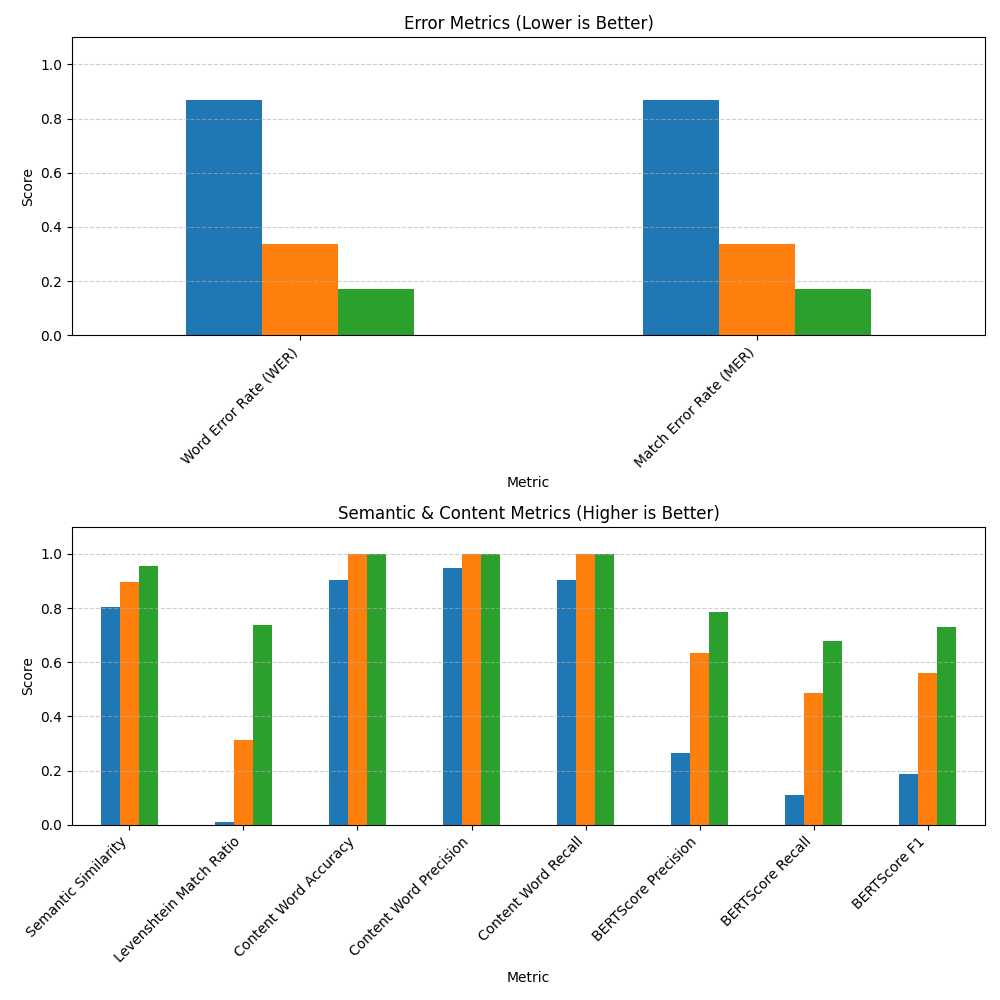

In [89]:
Image("../results/vis/vis_10.png")

# Video 11: Clara

In [98]:
df_video11 = pd.read_csv("../results/metrics/metrics_11.csv")

# Display DataFrame
df_video11

,Metric,Raw,Cleaned,No Fillers
0,Semantic Similarity,0.797,0.786,0.965
1,Word Error Rate (WER),0.852,0.521,0.182
2,Levenshtein Match Ratio,0.456,0.328,0.922
3,Match Error Rate (MER),0.852,0.521,0.179
4,Content Word Accuracy,0.892,0.947,0.949
5,Content Word Precision,0.917,0.947,1.000
6,Content Word Recall,0.892,0.947,0.949
7,BERTScore Precision,0.595,0.531,0.781
8,BERTScore Recall,0.104,-0.187,0.646
9,BERTScore F1,0.339,0.148,0.713


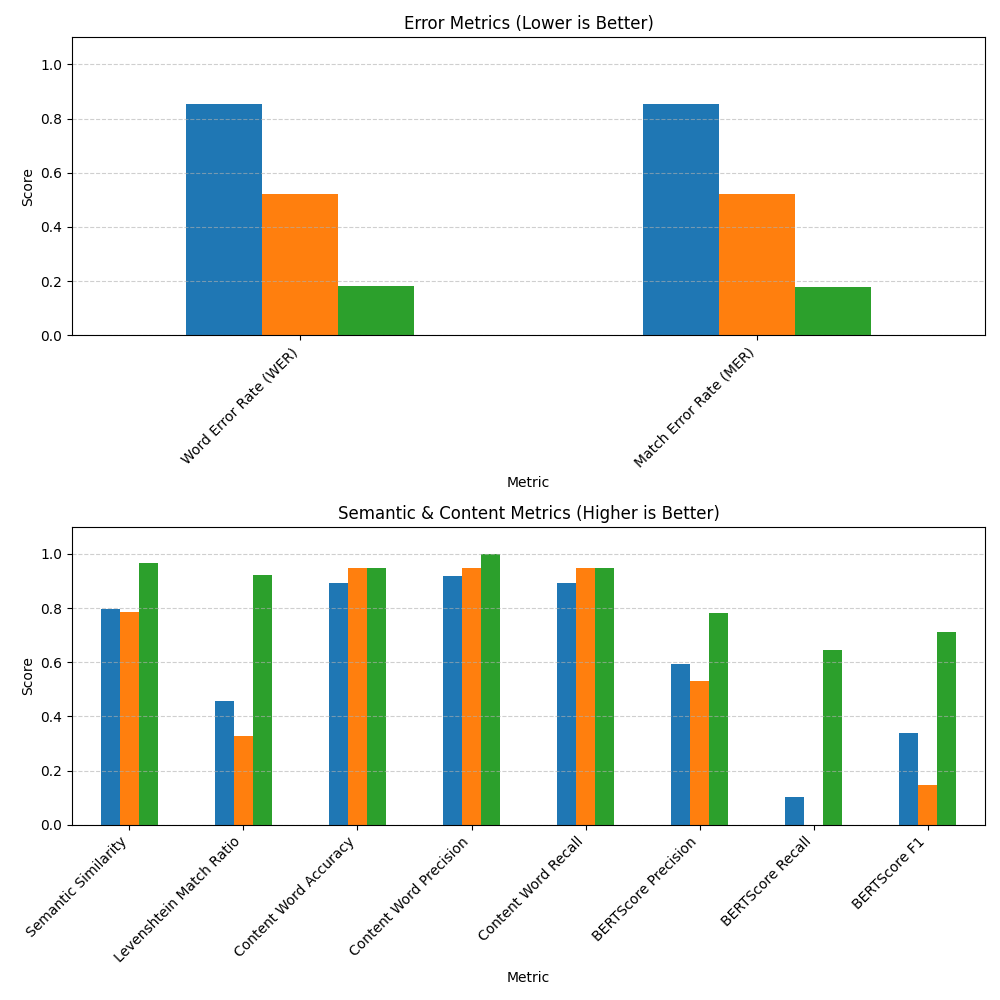

In [88]:
Image("../results/vis/vis_11.png")

# Video 12: Severe Aphasia

In [86]:
df_video12 = pd.read_csv("../results/metrics/metrics_12.csv")

# Display DataFrame
df_video12

,Metric,Raw,Cleaned,No Fillers
0,Semantic Similarity,0.826,0.945,0.934
1,Word Error Rate (WER),0.871,0.276,0.190
2,Levenshtein Match Ratio,0.032,0.858,0.903
3,Match Error Rate (MER),0.844,0.271,0.182
4,Content Word Accuracy,0.909,1.000,0.900
5,Content Word Precision,1.000,1.000,1.000
6,Content Word Recall,0.909,1.000,0.900
7,BERTScore Precision,0.235,0.737,0.812
8,BERTScore Recall,0.273,0.696,0.803
9,BERTScore F1,0.255,0.717,0.808


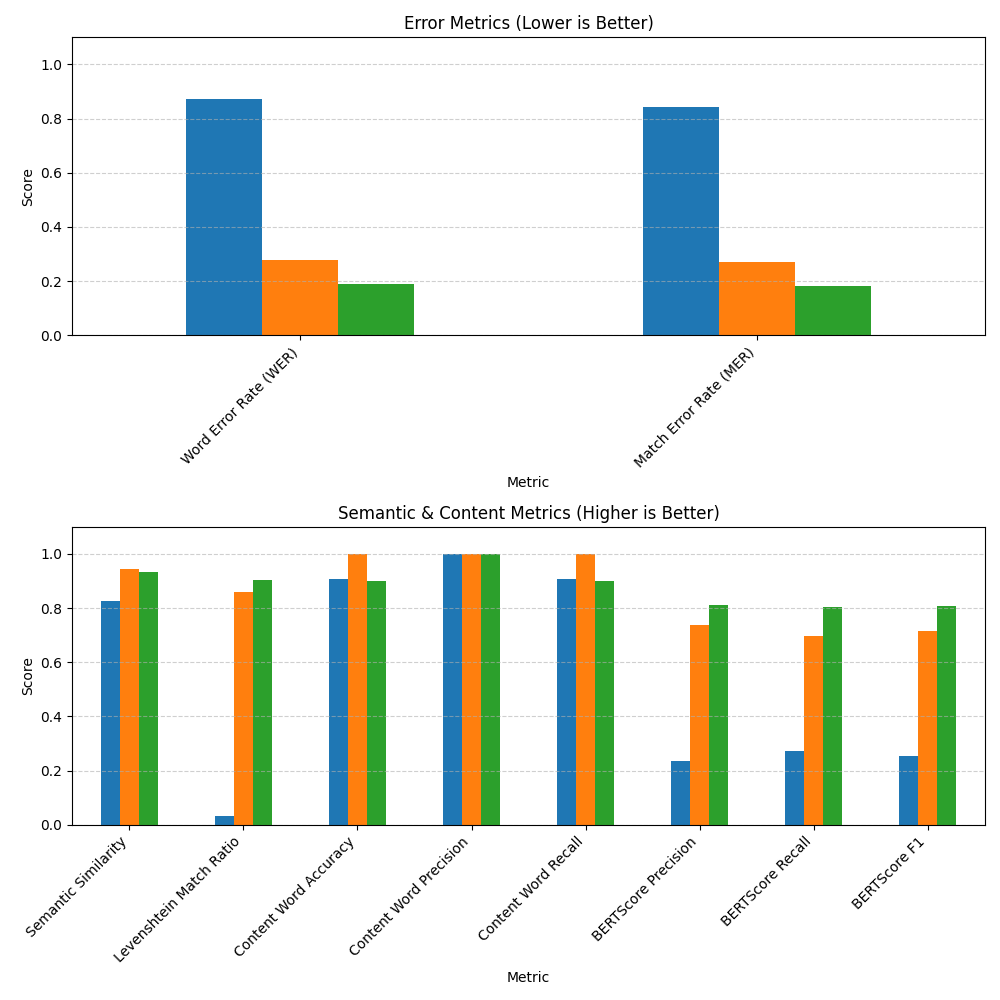

In [87]:
Image("../results/vis/vis_12.png")

# Video 13: Sarah

In [82]:
df_video13 = pd.read_csv("../results/metrics/metrics_13.csv")

# Display DataFrame
df_video13

,Metric,Raw,Cleaned,No Fillers
0,Semantic Similarity,0.998,0.999,0.999
1,Word Error Rate (WER),0.114,0.055,0.044
2,Levenshtein Match Ratio,0.965,0.981,0.985
3,Match Error Rate (MER),0.114,0.055,0.044
4,Content Word Accuracy,1.000,1.000,1.000
5,Content Word Precision,1.000,1.000,1.000
6,Content Word Recall,1.000,1.000,1.000
7,BERTScore Precision,0.916,0.959,0.951
8,BERTScore Recall,0.868,0.943,0.956
9,BERTScore F1,0.892,0.951,0.954


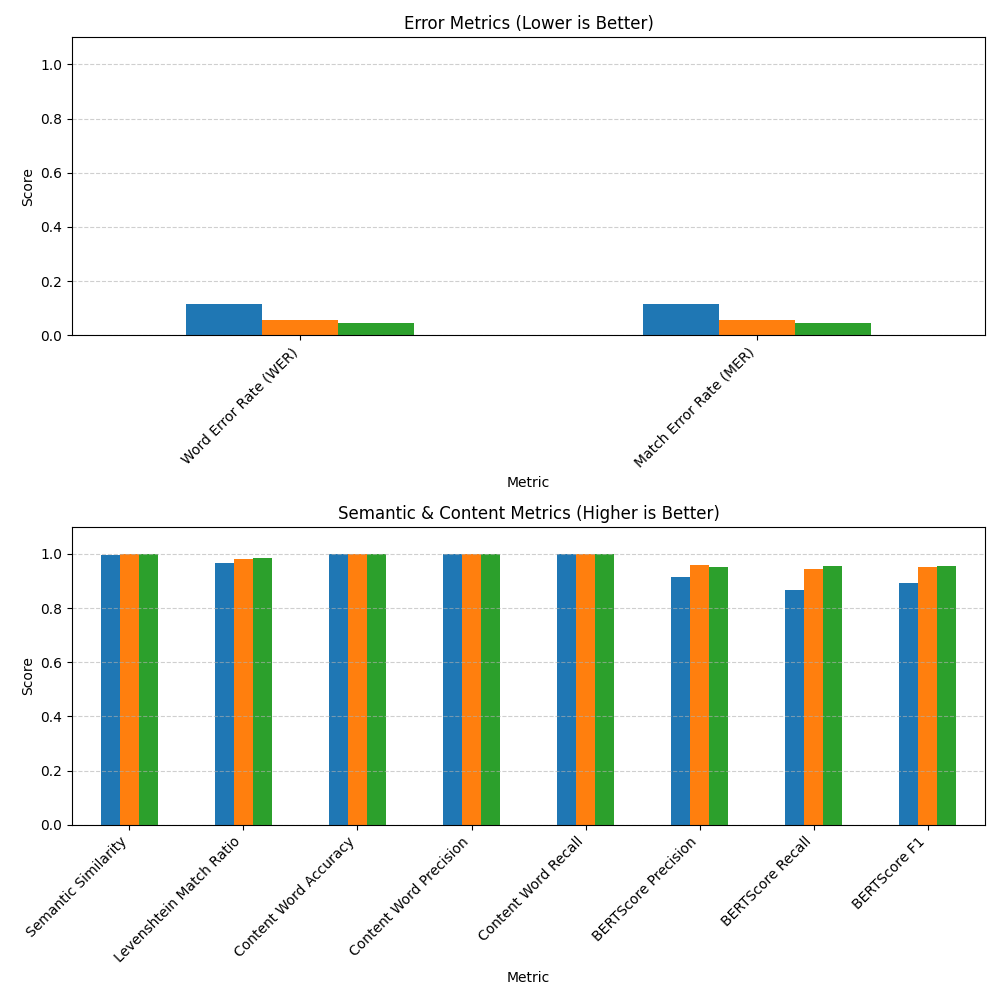

In [85]:
Image("../results/vis/vis_13.png")